In [7]:
import torch
from torchvision import datasets
from torchvision import transforms
data_path = 'D:/Data/CIFAR10/'
cifar10 = datasets.CIFAR10(data_path,
                           train=True,
                           download=False,
                           transform=transforms.Compose([
                               transforms.ToTensor(), # 如果没有这句在DataLoader的时候会出错
                               transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                    (0.2470, 0.2435, 0.2616))
                           ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
         for img, label in cifar10
         if label in [0, 2]]
cifar2_val = [(img, label_map[label])
             for img, label in cifar10_val
             if label in [0, 2]]

## 8.1 卷积介绍

> 如果想要识别出与物体相对应的图案，可能需要看看附近的像素是如何排列的。为了将这种直觉转化为数学系形式，我们可以计算一个像素与其相邻像素的加权和，而不是与图像中其他像素的加权和。这相当于构建权重矩阵，每个输出特征和输出像素位置都有一个权重矩阵，其中距离中心像素一定距离以外的所有权重都为0.这仍然是一个加权和，即线性运算。

> **卷积**，或者更准确地说，离散卷积，被定义为二维图像权重矩阵的标量积，即核函数与输入中的每个邻域的标量积

> 通过评议所有输入位置上的内核并执行加权和来创建输出图像。对于多通道图像，如RGB图像，权重矩阵将是一个$3\times 3\times 3$的矩阵：每个通道有一组权重，它们共同作用与输出值<br> 核中的权重是事先不知道的，但它们是随机初始化的，并通过反向传播进行更新。相同的核以及核中的每个券种在整幅图像中被重用。这意味着每个权重的使用都有一个跨越整个图像的历史值。因此，关于卷积权值的损失的导数包括来自整个图像的贡献

## 8.2 卷积实战

> torch.nn模块提供一维、二维、三维的卷积，其中nn.Conv1d用于时间序列，nn.Conv2d用于图像，nn.Conv3d用于体数据和视频

In [10]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
# kernel_size=3表示卷积核的大小是3*3，也可以直接使用kernel_size=(3, 3)
# 第1个3表示输入通道有3个，16表示有16个输出通道，所以完整的权重张量是16*3*3*3
conv
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

> 如果我们想用一个输入图像调用conv模块，我们需要通过unsqueeze()添加第0批处理维度，因为nn.Conv2d()期望输入一个$B\times C\times H\times W$的张量

In [11]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

> 输出的大小是torch.Size([1, 16, 30, 30])，在这个过程中丢失了一些像素，可以通过填充边界来修改

### 8.2.1 填充边界

> 在本例中，当kernel_size=3时指定padding=1意味着最左上角位置的上面和左面有一组额外的领域，这样即使在原始图像的角落也可以计算出卷积的输出。最终的结果是，输出图像与输入图像的大小完全相同

In [15]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # 填充
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

> 填充卷积主要有2个原因。首先，这样做可以帮助我们分离卷积和改变图像大小。其次，当我们有更复杂的结构，在卷积之前和之后，张量的大小是一致的，这样我们就可以将它们相加或者取差值

### 8.2.2 用卷积检测特征

> **检测**意味着输出具有较高的峰值。事实上，计算机视觉专家的工作一直以来就是设计出最有效的过滤器组合，使图像中突出的某些特征和物体能够被识别出来<br> 卷积神经网络的工作是估计连续层中的一组过滤器的卷积核，这些过滤器将把一个多通道图像转换成另一个多通道图像，其中不同的通道对应不同的特征，例如一个通道代表平均值，一个通道代表垂直边缘

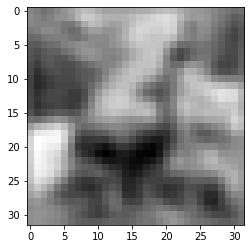

In [16]:
with torch.no_grad():
    conv.bias.zero_() # 将偏置归零
with torch.no_grad():
    conv.weight.fill_(1.0/9.0) # 先将偏置归零，然后将权重设置为一个常数值，这样输出中的每个像素都能得到其相邻像素的均值
# 我们可以使用conv.weight.one_()，会导致输出中的每个像素都是邻域中像素的和，差别不大，只是使输出图像中的值放大9倍
output = conv(img.unsqueeze(0)) # 看看以上操作对CIFAR图像的影响
import matplotlib.pyplot as plt
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

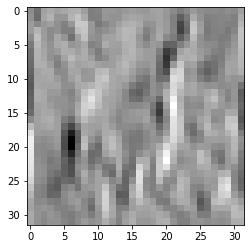

In [18]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]]) # 这是一个边缘检测核，卷积核突出显示2个水平相邻区域的垂直边缘
    conv.bias.zero_()
output = conv(img.unsqueeze(0)) # 看看以上操作对CIFAR图像的影响
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

### 8.2.3 使用池化技术（处理更大范围的图像）

> 若想处理更大范围的图像，一种方法是使用大的卷积核，但是我们会收敛到旧的全连接层，仿射变换失去了卷积所有优良性质；另一种方法是在一个卷积之后堆叠另一个卷积，同时在连续卷积之间对图像进行下采样

#### 从大到小：下采样

> 下采样可以以不同的方式进行，如将图像缩放一半相当于取4个相邻像素作为输入，产生一个像素作为输出<br> 最大池化由nn.MaxPool2d模块提供，将池化操作的邻域的大小作为输入

In [19]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### 将卷积和下采样结合

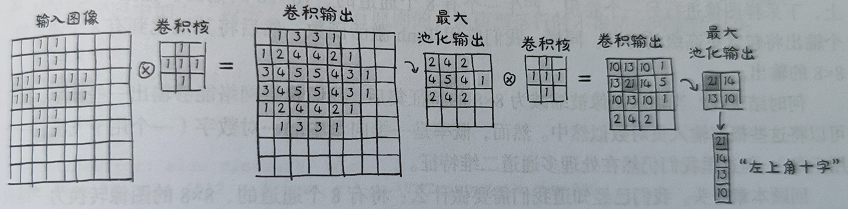

## 8.3 子类化nn.Module

> 当我们想要构建模型来做更复杂的事情，而不仅仅是一层接着一层应用时，我们需要放弃nn.Sequential运算带来的灵活性。PyTorch允许我们在模型中通过子类化nn.Module来进行任何运算。<p> 为了子类化nn.Module，我们至少需要定义一个forward()方法，该方法接收模块的输入并返回输出。<br> 通常情况下，运算将使用其他模块，例如内置的卷积或自定义的模块。为了包含这些子模块，我们通常在构造函数__init__()中定义它们，并将它们分配给self以便在forward()方法中使用。

### 8.3.1 将我们的网络作为一个nn.Module

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 第1个卷积将3个RGB通道带到16个RGB通道，32*32的图像
        self.act1 = nn.Tanh() # 然后应用Tanh活化函数，得到的有16个通道的，32*32的图像
        self.pool1 = nn.MaxPool2d(2) # 被池化成16个通道，16*16的图像
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) #第2个卷积将图像变为8个通道，16*16的图像
        self.act2 = nn.Tanh() # 应用Tanh()，仍是8个通道，16*16的图像
        self.pool2 = nn.MaxPool2d(2) # 池化后是8个通道，8*8的图像
        self.fc1 = nn.Linear(8*8*8, 32) # 所以此时的输入是8*8*8，线性化成32个输出（一个长度为32的向量）
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2) # 最终从32维的向量生成对于两个分类的概率
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 在调用view()时将批处理维度设置为-1，因为原则上我们不知道批次中将有多少个样本
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

> Net类相当于我们以前用子模块构建的模型nn.Sequential，但是通过显示地编写forward()方法，我们可以直接操作self.pool2的输出，并调用view()将其转换为一个$B\times N$的向量

> 分类网络的目标通常是压缩信息。首先，我们的目标是通过中间值的大小来反映的，通常收缩是通过减少卷积中的通道朱，通过池化减少像素的数量，以及通过在线性层中使输出维度低于输入维度来实现的。这是分类网络的一个共同特征。然而，在许多六性的架构中，收缩是通过空间分辨率池化实现的，但通道数量增加了（仍然导致维度大小减少）。快速信息收缩模式似乎适用于深度有限、图像较小的网络，但对于较深的网络，收缩速度通常较慢。其次，在一层中，相对输入大小（初始卷积），输出大小并没有减少。因此，第1层的特殊之处在于它极大地增加了流经它的数据的整体维度（如通道乘像素），但独立地考虑每个输出像素的映射仍然具有大约与输入一样的输出

### 8.3.2 PyTorch如何跟踪参数和子模块

> 给一个nn.Module的一个属性分配一个nn.Module实例，会自动将模块注册为子模块。子模块必须是顶级属性，而不是隐藏在list或dict实例中，否则优化器将无法定位子模块以及它们的参数。对于子模块需要列表和字典的情况，PyTorch提供nn.ModuleList和nn.ModuleDict

In [21]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

AttributeError: 'super' object has no attribute '__init__init__'

> 不管子模块如何嵌套，任何nn.Module都可以访问所有子模块的参数列表。通过访问子模块的grad属性，参数已由自动求导进行填充，优化器将知道如何更改参数以最小化损失

### 8.3.3 函数式API

> torch.nn.function提供了许多与nn中的模块类似的函数，但是它们不像模块那样处理输入实参和储存参数，二是将输入和参数作为函数调用的实参

In [43]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

> nn.Module API的内涵：模块是状态的容器，将参数和子模块的形式与指令相结合来完成转发<p> 是使用函数式API还是使用模块化API取决于开发者编码风格和具体使用场景体验。当网络的一部分比较简单，以至于我们想要使用nn.Sequential时，我们使用模块化API。当我们编写自己的forward()方法时，对于不需要以参数形式表示状态的内容，使用函数式接口可能会更自然

## 8.4 训练convnet

> convnet的核心是2个嵌套的循环：一个是跨迭代周期的外部循环，另一个是从数据集生成批次的DataLoader的内部循环。在每个循环中都要：
>> 通过模型提供输入（正向传播）<br> 计算损失（也是正向传播的一部分）<br> 将任何老的梯度归零<br> 调用loss.backward()来计算损失相对所有参数的梯度（反向传播）<br> 让优化器朝着更低的损失迈进

In [46]:
import datetime
import torch.optim as optim

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1): # 循环遍历从1到n_epochs，而不是从0开始
        loss_train = 0.0
        for imgs, labels in train_loader: # 在数据加载器为我们创建的批中循环数据集
            outputs = model(imgs) # 通过我们的模型提供一个批次……
            loss = loss_fn(outputs, labels) # 计算出我们希望最小化的损失
            optimizer.zero_grad() # 去掉最后一轮的梯度
            loss.backward() # 执行backward()，也就是说，计算所有我们希望网络学习的参数的梯度
            optimizer.step() # 更新模型
            loss_train += loss.item() # 对整个循环遍历中得到的损失求和。回想一下，使用item()方法将损失转换为一个数字很重要，以避免梯度变化
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {},Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) # 除以训练数据加载器的长度，得到每批平均损失，这是一种比求总和更直观的方法

In [48]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) # 数据加载器批量处理cifar2的样本数据集。随机打乱数据集中样本的顺序
model = Net() # 初始化网络
optimizer = optim.SGD(model.parameters(), lr=1e-2) # 随机梯度下降优化器
loss_fn = nn.CrossEntropyLoss() # 交叉熵损失
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2022-06-21 15:52:46.683847 Epoch 1,Training loss 0.5744125863928704
2022-06-21 15:53:08.455821 Epoch 10,Training loss 0.3312239787381166
2022-06-21 15:53:32.313286 Epoch 20,Training loss 0.2896455522080895
2022-06-21 15:53:56.074152 Epoch 30,Training loss 0.2671845439513018
2022-06-21 15:54:19.924527 Epoch 40,Training loss 0.2501349134524916
2022-06-21 15:54:43.740403 Epoch 50,Training loss 0.22822550190671995
2022-06-21 15:55:07.497286 Epoch 60,Training loss 0.213218642410579
2022-06-21 15:55:32.217889 Epoch 70,Training loss 0.19767422361928186
2022-06-21 15:55:56.095780 Epoch 80,Training loss 0.18360162284343864
2022-06-21 15:56:19.966953 Epoch 90,Training loss 0.16584242420021894
2022-06-21 15:56:43.812327 Epoch 100,Training loss 0.15322385903946154


### 8.4.1 用验证集验证

In [49]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # 在这里我们不需要梯度，因为我们不希望更新参数
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 将最大值的索引作为输出
                total += labels.shape[0] # 计算样本的数量，因此total会随着批处理的大小而增加
                correct += int((predicted == labels).sum()) # 比较具有最大概率的预测类和真实值标签，我们首先得到一个布尔数组。统计这个批次中预测值和实际值一致的项的总数
            
        print("Accuracy {}: {:.2f}".format(name, correct/total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


### 8.4.2 保存并加载模型

In [51]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt') # 保存模型

In [54]:
loaded_model = Net() # 必须确保在保存模型状态和稍后加载模型状态期间不会改变Net的定义
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 在GPU上训练

> nn.Module模块实现了一个将模型所有参数移动到GPU上的to()方法，当传递一个dtype参数时使用该方法还可以强制转换类型<br> Module.to和Tensor.to之间有一些微小的区别，区别在于模块实例是否被修改。对于Module.to来说，模块的实例会被修改，而Tensor.to会返回一个新的张量

> 如果GPU可用的话，把一切移到GPU上是一种很好的方式。一个好的模式是根据torch.cuda.is_available来设置一个变量device的值

In [55]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


> 然后可以通过Tensor.to()方法把数据加载器得到的丈量移动到GPU上来修正训练循环

In [64]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device) # 这两行代码将imgs和labels移动到我们正在训练的设备上，这是现在的代码与以前版本的唯一区别
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [65]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device) # 将我们的模型（所有参数）移动到GPU
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-06-21 20:11:21.868357 Epoch 1, Training loss 0.5875091943771217
2022-06-21 20:11:27.441613 Epoch 10, Training loss 0.3363154389106544
2022-06-21 20:11:33.627022 Epoch 20, Training loss 0.29846032390928573
2022-06-21 20:11:39.806307 Epoch 30, Training loss 0.2719478343322778
2022-06-21 20:11:46.018472 Epoch 40, Training loss 0.250987626896922
2022-06-21 20:11:52.227672 Epoch 50, Training loss 0.22862773065923886
2022-06-21 20:11:58.433416 Epoch 60, Training loss 0.20932187514889772
2022-06-21 20:12:04.665239 Epoch 70, Training loss 0.194947211653184
2022-06-21 20:12:10.881980 Epoch 80, Training loss 0.1794916655227637
2022-06-21 20:12:17.068418 Epoch 90, Training loss 0.16510960459709167
2022-06-21 20:12:23.269477 Epoch 100, Training loss 0.15111414703783715


> 加载网络权重时有一点儿复杂：PyTorch将尝试将权重加载到保存它的同一设备上。也就是说，GPU上的权重将恢复到GPU上。由于我们不知道是否需要相同的设备，我们有2个选择：在保存之前将网络移动到GPU，或者在恢复后将其移回。在加载权重时，指示PyTorch覆盖设备信息会更简洁一些。这是通过将map_lacation关键字参数传递给torch.load来实现的：

In [66]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## 8.5 模型设计

### 8.5.1 增加内存容量：宽度

> 在进入更复杂的问题时，首先要考虑网络的宽度：每层的神经元数，或每个卷积的通道数。我们只需在第1个卷积中指定更多的输出通道，并相应地增加后续的层数（注意改变前向函数），以反映这样一个事实：一旦切换到全连接层，我们将得到一个更长的向量

In [67]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(tourch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(tourch.tanh(self.conv2(out)), 2)
        out = out.view(-16, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

> 如果我们想避免在模型定义中硬编码数字，我们可以很容易地将一个参数传递给\_\_init_\_()并参数化宽度，同时注意在forward()方法中参数化对view()的调用

In [68]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [69]:
sum(p.numel() for p in model.parameters()) # 查看模型参数

18090

### 8.5.2 正则化

#### 1.检查参数：权重惩罚

> 稳定泛化的第1中方法是在损失中添加一个正则化项。这个术语的设计是为了减小模型本身的权重，从而限制训练对它们增长的影响。换句话说，这是对较大权重的惩罚。这使得损失更平滑，并且从拟合单个样本中获得的收益相对较少。这类较流行的正则化项是**L2正则化**，它是模型中所有权重的的平方和，而**L1正则化**是模型中所有权重的绝对值之和<br> L2正则化也称为权重衰减。在损失函数中加入L2正则化，相当于在优化步骤中将每个权重按其当前值的比例递减（因此称为权重衰减）

In [70]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # 对L1正则化则使用abs()替换pow(2.0)
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

> PyTorch中的SGD优化器已经有一个weight_decay参数，该参数对应2*lambda，它在前面描述的更新过程中直接执行权重衰减。它完全等价与在损失中加入L2范数，而不需要在损失中累加项，也不涉及自动求导

#### 2.Dropout

> **Dropout**是将网络每轮训练迭代中的神经元随机部分清零<br> Dropout在每次迭代中有效地生成具有不同神经元拓扑的模型，是的模型中的神经元在过拟合过程中协调记忆过程的机会更少。另一种观点是，Dropout在整个网络中干扰了模型生成的特征，产生了一种接近于增强的效果。<p> 在PyTorch中，我们可以通过在非线性激活与后面的线性或卷积模块之间添加一个nn.Dropout模块在模型中实现Dropout。作为一个参数，我们需要指定输入归零的概率。如果是卷积，我们将使用专门的nn.Dropout2d或者nn.Dropout3d，将输入的所有通道归零

In [71]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2dd(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

> PyTorch允许我们在任意nn.Model子类上通过调用model.train()或model.eval()来实现2种模式的切换

#### 3.批量归一化

> 批量归一化背后的主要思想是将输入重新调整到网络的激活状态，从而使小批量具有一定的理想分布<br> 批量归一化使用在该中间位置收集的小批量样本的平均值和标准差来对中间输入进行移位和缩放。正则化效应是这样一个事实的结果，即单个样本及其下游激活函数总是被模型视为平移和缩放，这取决于随机提取的小批量的统计数据，这本身就是一种原则性的增强。使用批量归一化可以消除或减轻对Dropout的需要。<p> PyTorch提供了nn.BatchNorm1d、nn.BatchNorm2d和nn.BatchNorm3d来实现批量归一化，由于批量归一化的目的是重新调整激活的输入，因此其位置是在线性变换（或卷积）和激活函数之后

In [72]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8*8*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8*8*self.n_chans1hans1 // 2)
        out = torch.tanhh(self.fc1(out))
        out = self.fc2(out)
        return out

### 8.5.3 深度

#### 1.跳跃连接

> **跳跃连接**是将输入添加到层快的一个输出中<br> 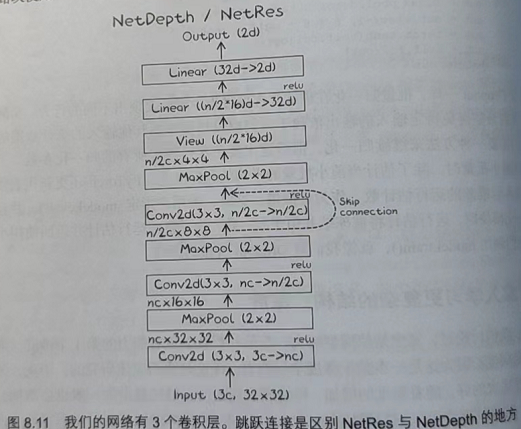

> 在简单的卷积模型中添加一层，并改变激活函数。带有额外层的普通模块如下：

In [ ]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.reluu(self.fc1(out))
        out = self.fc2(out)
        return out

> 仿照ResNet向这个模型添加一个跳跃连接，相当于forward()方法函数中将1层的输出添加到第3层的输入中：

In [73]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1n(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2n(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out1.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### 2.使用PyTorch建立非常深的模型

> 标准的策略是定义一个构建块，例如一个Conv2d、ReLU再加跳跃连接块，然后在for循环中动态构建网络

In [74]:
# 创建一个模块子类，它唯一的任务是为一个块提供计算，该块包含一组卷积、激活函数和跳跃连接
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, #批范数层会抵消偏置的影响，因此它通常被排除在外
                                      nonlinearity='relu') # 使用自定义的初始化。kaiming_normal_()用ResNet论文中计算标准差的正态随机元素初始化。批范数被初始化以产生初始时平均值为0和方差为为0.5的输出分布
        torch.nn.init.constant_(self.batch_normtch_norm.bias)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

> 首先，在\_\_init_\_()中，创建了一个包括残差块实例列表的nn.Sequential。nn.Sequential将确保一个块的输出被用作下一个块的输入。然后，在forward()中，只需调用nn.Sequential来遍历100个块并生成输出 

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks*[ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out